<a href="https://colab.research.google.com/github/dvij542/IAC-Controls/blob/main/odms_lec27_coKrg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# GPR In-house v2

# Kriging kernel function
def krg_kernel(x1, x2, theta, power):
  # Flatten inputs
  x1 = x1.flatten()
  x2 = x2.flatten()
  theta = theta.flatten()
  power = power.flatten()
  # Number of dimensions
  k = x1.size
  weighted_distance = 0 
  for i in range(k):
      weighted_distance += theta[i]*(np.abs(x1[i] - x2[i]))**power[i]
  PsiVal = np.exp(-weighted_distance)
  return PsiVal
  
# Correlation vector function
def cor_vector(kernel, x_train, x_target, theta, power):
  n, k = x_train.shape
  PsiVec = np.zeros((n, 1))
  for i in range(n):
    PsiVec[i] = kernel(x_train[i:i+1,:], x_target, theta, power)
  return PsiVec
  
# Correlation matrix function
def cor_matrix1(kernel, x_train, theta, power, Lambda=0):
  n, k = x_train.shape
  PsiMat = np.zeros((n, n))
  for i in range(n):
      for j in range(n):
          PsiMat[i,j] = kernel(x_train[i:i+1,:], x_train[j:j+1,:], theta, power)
  return PsiMat + Lambda*np.eye((n))
 

# Correlation matrix function
def cor_matrix(kernel, x_train, theta, power, Lambda=0):
  n, k = x_train.shape
  PsiMat = np.empty((n,0))
  for i in range(n):
    x_target = x_train[i,:]
    PsiVec = cor_vector(kernel, x_train, x_target, theta, power)
    PsiMat = np.block([PsiMat, PsiVec])
  return PsiMat + Lambda*np.eye((n))


# Correlation matrix function
def cor_matrix2(kernel, x_train1, x_train2, theta, power, Lambda=0):
  n1, k = x_train1.shape
  n2, k = x_train2.shape
  PsiMat = np.zeros((n1, n2))
  for i in range(n1):
      for j in range(n2):
          PsiMat[i,j] = kernel(x_train[i:i+1,:], x_train[j:j+1,:], theta, power)
  return PsiMat

# Gaussian process regression (GPR)
def GP_regression(kernel, x_train, y_train, x_target, theta, power, Lambda=0):
    n, k = x_train.shape
    # Correlation vector
    PsiVec = cor_vector(kernel, x_train, x_target, theta, power)
    PsiVecTr = np.transpose(PsiVec)
    # Correlation matrix
    PsiMat = cor_matrix(kernel, x_train, theta, power, Lambda)
    PsiMatInv = np.linalg.inv(PsiMat)
    # Regression mean
    OnesVec = np.ones((n, 1))
    OnesVecTr = np.transpose(OnesVec)
    mu_num = (OnesVecTr @ PsiMatInv) @ y_train
    mu_den = (OnesVecTr @ PsiMatInv) @ OnesVec
    mu = mu_num/mu_den
    # GP predictive mean 
    y_hat = mu + (PsiVecTr@PsiMatInv)@(y_train - OnesVec*mu)
    # GP predictive variance
    muVec = mu*OnesVec
    sigma2 = 1/n*((np.transpose(y_train-muVec) @ PsiMatInv) @ (y_train-muVec))
    s2 = sigma2*(1 - (np.transpose(PsiVec)@PsiMatInv) @ PsiVec)
    return y_hat, s2

# Leave-one-out cross validation error (CVE) function
def CVE_fun(kernel, x_train, y_train, theta, power, Lambda=0):
  n, k = x_train.shape
  erVec = np.zeros((n, 1))
  # Evaluate surrogates
  for i in range(n):
      # Remove training data
      x_temp = 1*x_train
      y_temp = 1*y_train 
      x_temp = np.delete(x_train, i, 0)
      y_temp = np.delete(y_train, i, 0)
      # Evaluate surrogate at removed point
      x_target = x_train[i]
      y_true = y_train[i]
      y_pred, s2 = GP_regression(kernel, x_temp, y_temp, x_target, theta, power, Lambda)
      erVec[i] = y_true - y_pred
  # CVE calculation
  erVecTr = np.transpose(erVec)
  pressVal = erVecTr@erVec
  return pressVal #, erVec

# Concentrated log-likelihood function
def logLfun(kernel, x_train, y_train, theta, power, Lambda=0):
  n, k = x_train.shape
  # Correlation matrix
  PsiMat = cor_matrix(kernel, x_train, theta, power, Lambda)
  PsiMatInv = np.linalg.inv(PsiMat)
  PsiMatDet = np.linalg.det(PsiMat)
  PsiMatDetLog = np.log(PsiMatDet)
  # GP mean
  OnesVec = np.ones((n, 1))
  OnesVecTr = np.transpose(OnesVec)
  mu_num = (OnesVecTr @ PsiMatInv) @ y_train
  mu_den = (OnesVecTr @ PsiMatInv) @ OnesVec
  mu = mu_num/mu_den
  # GP variance
  y1mu = y_train - OnesVec*mu
  y1muTr = np.transpose(y1mu)
  sigma2 = 1/n*(y1muTr@PsiMatInv)@y1mu
  sigma2Log = np.log(sigma2)
  # Log-likelihood
  logL = -n/2*sigma2Log - 1/2*PsiMatDetLog
  return logL


In [ ]:
# Co_krg sigma2
def sigma2fun(kernel, x_train, y_train, theta, power, Lambda=0):
    n, k = x_train.shape

    # Correlation matrix
    PsiMat = cor_matrix(kernel, x_train, theta, power, Lambda)
    PsiMatInv = np.linalg.inv(PsiMat)

    # Regression mean
    OnesVec = np.ones((n, 1))
    OnesVecTr = np.transpose(OnesVec)
    # Mean
    mu_num = (OnesVecTr @ PsiMatInv) @ y_train
    mu_den = (OnesVecTr @ PsiMatInv) @ OnesVec
    mu = mu_num/mu_den

    # GP predictive variance
    muVec = mu*OnesVec
    sigma2 = 1/n*((np.transpose(y_train-muVec) @ PsiMatInv) @ (y_train-muVec))
    return sigma2


# Gaussian process regression (GPR)
def GP_regression2(kernel, x_train1, x_train2, y_train1, y_train2, x_target, theta1, theta2, power, rho=1, Lambda=0):
    n1, k = x_train1.shape
    n2, k = x_train2.shape

    # Correlation vector
    PsiVec = cor_vector(kernel, x_train, x_target, theta, power)
    PsiVecTr = np.transpose(PsiVec)
    # Correlation matrix
    PsiMat = cor_matrix(kernel, x_train, theta, power, Lambda)
    PsiMatInv = np.linalg.inv(PsiMat)
    # Regression mean
    OnesVec = np.ones((n, 1))
    OnesVecTr = np.transpose(OnesVec)
    mu_num = (OnesVecTr @ PsiMatInv) @ y_train
    mu_den = (OnesVecTr @ PsiMatInv) @ OnesVec
    mu = mu_num/mu_den
    # GP predictive mean 
    y_hat = mu + (PsiVecTr@PsiMatInv)@(y_train - OnesVec*mu)
    # GP predictive variance
    muVec = mu*OnesVec
    sigma2 = 1/n*((np.transpose(y_train-muVec) @ PsiMatInv) @ (y_train-muVec))
    s2 = sigma2*(1 - (np.transpose(PsiVec)@PsiMatInv) @ PsiVec)
    return y_hat, s2


In [62]:
# Expensive function
def efun(x):
  return (6*x - 2)**2*np.sin(12*x - 4)

# Cheap function
def cfun(x):
  return 0.5*efun(x) + 10*(x - 0.5) + 5

In [63]:
# Sampling plans
xe_train = np.array([0.0, 0.4, 0.6, 1.0]).reshape(-1,1)
xc_train = np.linspace(0,1,11).reshape(-1,1)
# print(xe_train, xc_train)

# Observations
ye_train = efun(xe_train)
yc_train = cfun(xc_train)
# print(ye_train, yc_train)

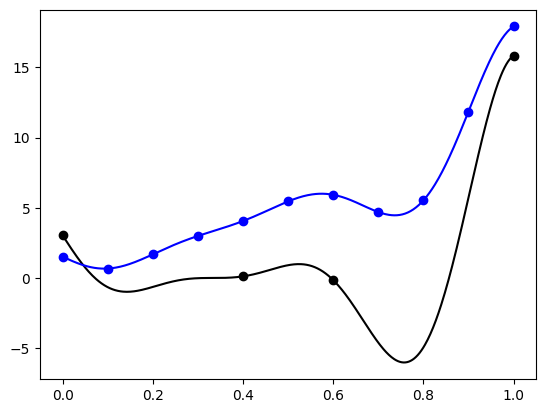

In [64]:
# Plots
xplt = np.linspace(0,1,500)
yeplt = efun(xplt)
ycplt = cfun(xplt)

plt.plot(xplt, yeplt, c='k')
plt.plot(xplt, ycplt, c='b')
plt.scatter(xe_train, ye_train, c='k')
plt.scatter(xc_train, yc_train, c='b')
plt.show()

In [65]:
# Expensive GPR 
kernel = krg_kernel
x_train = xe_train
y_train = ye_train
theta = np.array([[1]])
power = np.array([[2]])
Lambda = 0

# Cor mat
K = cor_matrix(kernel, x_train, theta, power, Lambda=0)
print(K)

[[1.         0.85214379 0.69767633 0.36787944]
 [0.85214379 1.         0.96078944 0.69767633]
 [0.69767633 0.96078944 1.         0.85214379]
 [0.36787944 0.69767633 0.85214379 1.        ]]


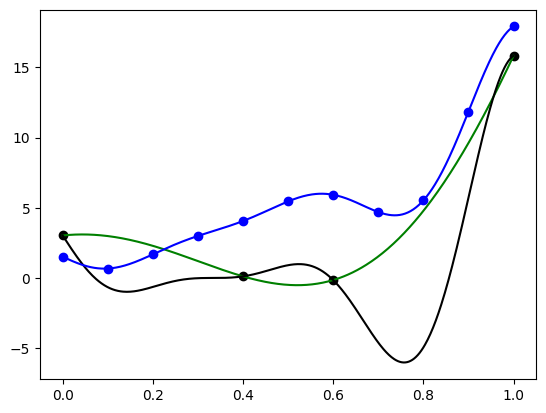

In [66]:
ye = np.empty(xplt.shape)
s2e = np.empty(xplt.shape)
for i in range(len(xplt)):
  x_target = xplt[i]
  ye[i], s2e[i] = GP_regression(kernel, x_train, y_train, x_target, theta, power, Lambda)

# Plot
plt.plot(xplt, ye, c='g')
plt.plot(xplt, yeplt, c='k')
plt.plot(xplt, ycplt, c='b')
plt.scatter(xe_train, ye_train, c='k')
plt.scatter(xc_train, yc_train, c='b')
plt.show()